# Imports

In [ ]:
!pip install demoji

     |████████████████████████████████| 42 kB 616 kB/s 


In [ ]:
import numpy as np
import pandas as pd
import json
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from google.colab.data_table import DataTable
DataTable.max_columns = 400
import statsmodels.api as sm
import numpy as np
import json
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

from PIL import Image
from torchvision import transforms, models
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torchvision.utils import make_grid
import torch.optim as optim
import matplotlib.pyplot as plt
import tqdm

from nltk.sentiment import SentimentIntensityAnalyzer
import demoji
import nltk
nltk.download('vader_lexicon')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True) 

Mounted at /content/drive


# Set device and random seed


In [ ]:
# @title Set random seed

# @markdown Executing `set_seed(seed=seed)` you are setting the seed

# For DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.
import random
import torch

def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness. NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [ ]:
# @title Set device (GPU or CPU). Execute `set_device()`
# especially if torch modules used.

# Inform the user if the notebook uses GPU or CPU.

def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

In [ ]:
# @title set seed and device
SEED = 31
set_seed(seed=SEED)
DEVICE = set_device()

Random seed 31 has been set.
GPU is enabled in this notebook.


# Load Data

In [ ]:
df = pd.read_csv('/content/drive/Shareddrives/CIS 522/code/input/TikTok Data/batch_4_100000/data_cleaned_50perc_viral.csv')
df = df.drop(columns=["Unnamed: 0"])
df

,id,text,caption_pp,author_verification,authorMeta.following,authorMeta.fans,authorMeta.heart,authorMeta.video,authorMeta.digg,music_original,...,effect_Sticker su schermo verde,effect_Shapeshifting,effect_Vintage DV,effect_Mega Mouth,effect_Color Customizer,effect_Outline,effect_Color Selector,effect_Greenscreen,effect_Scrolling Text,label
0,6862153058223197445,To the 🐝 🐝 🐝 #fyp,18,1,589,89100000,2100000000,458,8327,0,...,0,0,0,0,0,0,0,0,0,0
1,6911406868699073798,😳This is one of my best drawings #dlaciebie #t...,69,1,99,11800000,233100000,193,27800,0,...,0,0,0,0,0,0,0,0,0,0
2,7028775404173413678,bruh this shit has me WHEEZING #fyp,35,0,166,987000,40400000,3,8148,1,...,0,0,0,0,0,0,0,0,0,1
3,6975140587196517638,"Fill the cheeks Squishy, fill the cheeks #fyp ...",94,0,51,13300000,171800000,443,9341,1,...,0,0,0,0,0,0,0,0,0,0
4,6984473039605959941,#fyp #foryou #foryoupage,24,0,9861,2900000,39000000,1093,15600,1,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
970,6889900644510059781,Christmas lollipop made out of pool noodles. S...,126,0,9948,1100000,13900000,263,55400,0,...,0,0,0,0,0,0,0,0,0,1
971,6814512525250530566,Embracing our cultures #fyp #foryou #foryoupag...,146,0,395,1600000,38400000,1025,74900,0,...,0,0,0,0,0,0,0,0,0,1
972,6983419881379155206,why do men like this exist ? #fyp,33,0,155,4400000,106700000,618,14600,1,...,0,0,0,0,0,0,0,0,0,0
973,6820442532665707782,Please don’t be ugly 🐼#fyp #foryou #foryoupage,46,1,376,9200000,223600000,600,353,1,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
test_size = 0.2
train_df = df.sample(frac=1-test_size)
test_df = df.drop(train_df.index)
train_df.reset_index(inplace=True,drop=True)
test_df.reset_index(inplace=True,drop=True)


# scaling
scaler = StandardScaler()
x_cols = train_df.drop(columns=['id','text', 'label']).columns
train_df[x_cols] = scaler.fit_transform(train_df[x_cols])
test_df[x_cols] = scaler.transform(test_df[x_cols])

# Modality 1: Metadata

## Dataloaders

In [ ]:
class TikTokDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.input_size = (120*16,120*9)
        self.transform_meta = transforms.Compose([
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.df['id'])

    def __getitem__(self, idx):
        meta = torch.Tensor(self.df.drop(columns=['id', 'label', 'text']).loc[idx])
        label = self.df.loc[idx]['label']
        return meta, label

In [ ]:
# To preserve reproducibility
g_seed = torch.Generator()
g_seed.manual_seed(SEED)
batch_size = 32

# Load data
train_loader = DataLoader(TikTokDataset(train_df),
                          num_workers=0, 
                          batch_size=batch_size,
                          shuffle=True,
                          worker_init_fn=seed_worker,
                          generator=g_seed)
test_loader = DataLoader(TikTokDataset(test_df), 
                         num_workers=0, 
                         batch_size=batch_size,
                         shuffle=False,
                         worker_init_fn=seed_worker,
                         generator=g_seed)

## `train()`, `eval()`, `get_predictions()` functions

In [ ]:
# Train
def train(model, optimizer, train_loader,
                          loss_fn, device, num_epochs=5):
  """
  Training loop

  Args:
    model: nn.module
      Untrained model
    optimizer: function
      Optimizer
    train_loader: torch.loader
      Training loader
    loss_fn: function
      Criterion
    device: string
      If available, GPU/CUDA. CPU otherwise

  Returns:
    model: nn.module
      Trained model
    train_loss: List(float)
      List of train losses at each epoch
    train_acc: List(float)
      List of train accuracies at each epoch
  """
  train_loss = []
  train_acc = []

  for epoch in tqdm.notebook.tqdm(range(num_epochs)):
    # Set model to use the classifier head
    model.train()

    # Train on a batch of images
    
    running_loss = []
    running_acc = []

    for batch in train_loader:
      meta, labels = batch

      meta = meta.to(device)
      labels = labels.to(device)

      # output from model
      outputs = model(meta)

      optimizer.zero_grad()
      loss = loss_fn(outputs, labels)
      loss.backward()
      optimizer.step()

      _, predicted = torch.max(outputs.data, 1)

      running_loss.append(loss.item())
      running_acc.append((predicted == labels).sum().item()/labels.size(0))

    train_loss.append(np.mean(running_loss))
    train_acc.append(np.mean(running_acc))

  return model, train_loss, train_acc

In [ ]:
# Evalute
def eval(model, test_loader, loss_fn, device, num_epochs=5):
  """
  Evaluation loop

  Args:
    model: nn.module
      Untrained model
    test_loader: torch.loader
    loss_fn: function
      Criterion
    device: string
      If available, GPU/CUDA. CPU otherwise

  Returns:
    test_loss: List(float)
      List of test losses at each epoch
    test_acc: List(float)
      List of test accuracies at each epoch
  """

  test_loss = []
  test_acc = []

  for epoch in tqdm.notebook.tqdm(range(num_epochs)):
    # Set model to use the classifier head
    model.eval()
    # Evaluate model on a batch of images
    running_loss = []
    running_acc = []

    for batch in test_loader:
      meta, labels = batch

      meta = meta.to(device)
      labels = labels.to(device)

      # output from model
      outputs = model(meta)

      loss = loss_fn(outputs, labels)
      
      _, predicted = torch.max(outputs.data, 1)
      
      running_loss.append(loss.item())
      running_acc.append((predicted == labels).sum().item()/labels.size(0))

    test_loss.append(np.mean(running_loss))
    test_acc.append(np.mean(running_acc))

  return test_loss, test_acc

In [ ]:
def get_predictions(model, test_loader, device):
  y_pred = []
  y_true = []
  model.eval()
  for batch in test_loader:
      meta, labels = batch

      meta = meta.to(device)
      labels = labels.to(device)

      # output from model
      outputs = model(meta)

      _, predicted = torch.max(outputs.data, 1)
      y_true.append(labels.cpu().numpy())
      y_pred.append(predicted.cpu().numpy())
  y_true = np.concatenate(tuple(y_true))
  y_pred = np.concatenate(tuple(y_pred))
  return y_true, y_pred
  

## Logistic Regression

In [ ]:
class LogisticRegression(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, x):
        out = self.linear(x)
        return out

In [ ]:
input_size = train_df.drop(columns=['id', 'label', 'text']).shape[1]

# Fully Connected NN for metadata
meta_logreg = LogisticRegression(input_size, 2).to(DEVICE)

opt = torch.optim.Adam(meta_logreg.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()
num_epochs = 30

# Train
meta_logreg, train_loss, train_acc = train(
    meta_logreg, opt, train_loader, loss_fn, DEVICE, num_epochs=num_epochs)

# Evaluate
test_loss, test_acc = eval(
    meta_logreg, test_loader, loss_fn, DEVICE, num_epochs=num_epochs)

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

### Results

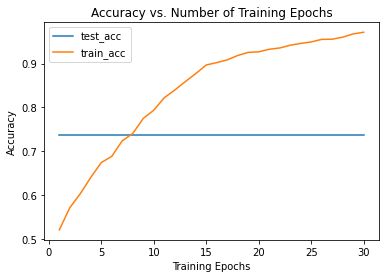

In [ ]:
plt.title("Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Accuracy")
plt.plot(range(1,len(test_acc)+1),test_acc,label="test_acc")
plt.plot(range(1,len(train_acc)+1),train_acc,label="train_acc")
plt.legend()
plt.savefig("/content/drive/Shareddrives/CIS 522/code/output/{}_{}.png".format("logreg_nonDL", "acc"))
plt.show()

In [ ]:
print(test_loss)

[0.7028982639312744, 0.7028982639312744, 0.7028982639312744, 0.7028982639312744, 0.7028982639312744, 0.7028982639312744, 0.7028982639312744, 0.7028982639312744, 0.7028982639312744, 0.7028982639312744, 0.7028982639312744, 0.7028982639312744, 0.7028982639312744, 0.7028982639312744, 0.7028982639312744, 0.7028982639312744, 0.7028982639312744, 0.7028982639312744, 0.7028982639312744, 0.7028982639312744, 0.7028982639312744, 0.7028982639312744, 0.7028982639312744, 0.7028982639312744, 0.7028982639312744, 0.7028982639312744, 0.7028982639312744, 0.7028982639312744, 0.7028982639312744, 0.7028982639312744]


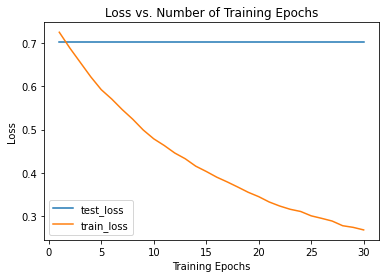

In [ ]:
plt.title("Loss vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Loss")
plt.plot(range(1,len(test_loss)+1),test_loss,label="test_loss")
plt.plot(range(1,len(train_loss)+1),train_loss,label="train_loss")
plt.legend()
plt.savefig("/content/drive/Shareddrives/CIS 522/code/output/{}_{}.png".format("logreg_nonDL", "loss"))
plt.show()

In [ ]:
y_true, y_pred = get_predictions(meta_logreg, test_loader, DEVICE)
print(classification_report(y_true, y_pred))
print(confusion_matrix(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.82      0.78       106
           1       0.76      0.66      0.71        89

    accuracy                           0.75       195
   macro avg       0.75      0.74      0.74       195
weighted avg       0.75      0.75      0.75       195

[[87 19]
 [30 59]]


## DL model

In [ ]:
class Net(nn.Module):
    def __init__(self, actv, num_inputs, hidden_units, num_outputs):
        super(Net, self).__init__()

        # Assign activation function (exec allows us to assign function from string)
        exec('self.actv = nn.%s'%actv)  

        # Initialize layers of MLP
        self.layers = nn.ModuleList()
        self.num_inputs = num_inputs

        # Loop over layers and create each one
        for i in range(len(hidden_units)):
          next_num_inputs = hidden_units[i] 
          self.layers += [nn.Linear(num_inputs, next_num_inputs), nn.Dropout(0.2)]
          num_inputs = next_num_inputs

        # Create final layer
        self.out = nn.Linear(num_inputs, num_outputs)

    def forward(self, x):
        # Flatten inputs to 2D (if more than that)
        x = x.view(-1, self.num_inputs)

        # Get activations of each layer
        for layer in self.layers:
          x = self.actv(layer(x))

        # Get outputs
        x = self.out(x) 

        return x

In [ ]:
input_size = train_df.drop(columns=['id', 'label', 'text']).shape[1]

# Fully Connected NN for metadata
meta_net = Net(actv='ReLU()',
    num_inputs = input_size,
    hidden_units = [512, 64],
    num_outputs = 2).to(DEVICE)

opt = torch.optim.Adam(meta_net.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()
num_epochs = 30

# Train
meta_net, train_loss, train_acc = train(
    meta_net, opt, train_loader, loss_fn, DEVICE, num_epochs=num_epochs)

# Evaluate
test_loss, test_acc = eval(
    meta_net, test_loader, loss_fn, DEVICE, num_epochs=num_epochs)

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

### Results

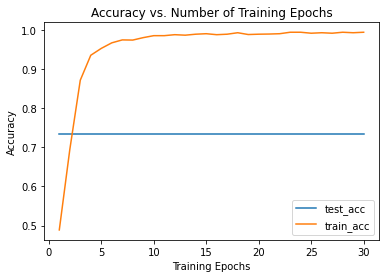

In [ ]:
plt.title("Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Accuracy")
plt.plot(range(1,len(test_acc)+1),test_acc,label="test_acc")
plt.plot(range(1,len(train_acc)+1),train_acc,label="train_acc")
plt.legend()
plt.savefig("/content/drive/Shareddrives/CIS 522/code/output/{}_{}.png".format("meta_DL_w_dropout", "acc"))
plt.show()

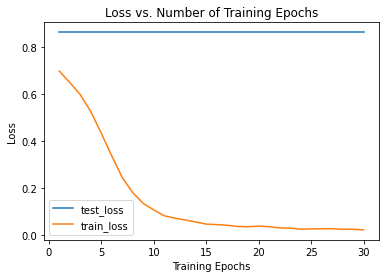

In [ ]:
plt.title("Loss vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Loss")
plt.plot(range(1,len(test_loss)+1),test_loss,label="test_loss")
plt.plot(range(1,len(train_loss)+1),train_loss,label="train_loss")
plt.legend()
plt.savefig("/content/drive/Shareddrives/CIS 522/code/output/{}_{}.png".format("meta_DL_w_dropout", "loss"))
plt.show()

In [ ]:
y_true, y_pred = get_predictions(meta_net, test_loader, DEVICE)
print(classification_report(y_true, y_pred))
print(confusion_matrix(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.84      0.78       106
           1       0.77      0.63      0.69        89

    accuracy                           0.74       195
   macro avg       0.75      0.73      0.74       195
weighted avg       0.75      0.74      0.74       195

[[89 17]
 [33 56]]


# Modality 2: Text

## Sentiment Analysis

In [ ]:
train_df["transcribed"] = train_df["text"].apply(lambda x: demoji.replace_with_desc(x, " "))
train_df = train_df.drop("text", axis=1)
sia = SentimentIntensityAnalyzer()
train_df["sentiment"] = train_df["transcribed"].apply(lambda x: sia.polarity_scores(x)["compound"])

test_df["transcribed"] = test_df["text"].apply(lambda x: demoji.replace_with_desc(x, " "))
test_df = test_df.drop("text", axis=1)
sia = SentimentIntensityAnalyzer()
test_df["sentiment"] = test_df["transcribed"].apply(lambda x: sia.polarity_scores(x)["compound"])
test_df[['transcribed', 'sentiment']].head()

,transcribed,sentiment
0,why so emotional #fyp,0.2247
1,Ultimate boy dad #HoldMyMilk #fyp #foryou #mo...,0.0000
2,@malek sameh 님과 #이어찍기 #추천 #fyp #viral #xyzbca ...,0.0000
3,they be doing too much #foryou #fyp #parents,0.0000
4,Wait for it... #RN #nurse #fyp #foryoupage #we...,0.0000


## Dataloaders w/ sentiment

In [ ]:
class TikTokDataset(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df['id'])

    def __getitem__(self, idx):
        meta = torch.Tensor(self.df.drop(columns=['id', 'label', 'transcribed']).loc[idx])
        label = self.df.loc[idx]['label']
        return meta, label

In [ ]:
# To preserve reproducibility
g_seed = torch.Generator()
g_seed.manual_seed(SEED)
batch_size = 32

# Load data
train_loader = DataLoader(TikTokDataset(train_df),
                          num_workers=0, 
                          batch_size=batch_size,
                          shuffle=True,
                          worker_init_fn=seed_worker,
                          generator=g_seed)
test_loader = DataLoader(TikTokDataset(test_df), 
                         num_workers=0, 
                         batch_size=batch_size,
                         shuffle=False,
                         worker_init_fn=seed_worker,
                         generator=g_seed)

## Logistic Regression

In [ ]:
class LogisticRegression(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, x):
        out = self.linear(x)
        return out

In [ ]:
input_size = train_df.drop(columns=['id', 'label', 'transcribed']).shape[1]

# Fully Connected NN for metadata
meta_logreg = LogisticRegression(input_size, 2).to(DEVICE)

opt = torch.optim.Adam(meta_logreg.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()
num_epochs = 30

# Train
meta_logreg, train_loss, train_acc = train(
    meta_logreg, opt, train_loader, loss_fn, DEVICE, num_epochs=num_epochs)

# Evaluate
test_loss, test_acc = eval(
    meta_logreg, test_loader, loss_fn, DEVICE, num_epochs=num_epochs)

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

### Results

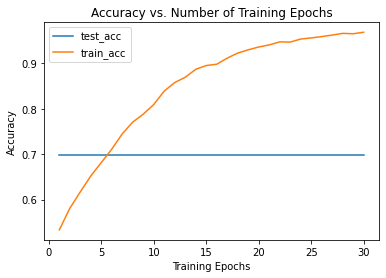

In [ ]:
plt.title("Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Accuracy")
plt.plot(range(1,len(test_acc)+1),test_acc,label="test_acc")
plt.plot(range(1,len(train_acc)+1),train_acc,label="train_acc")
plt.legend()
plt.savefig("/content/drive/Shareddrives/CIS 522/code/output/{}_{}.png".format("logreg_nonDL_w_sentiment", "acc"))
plt.show()

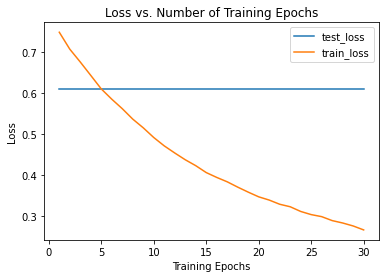

In [ ]:
plt.title("Loss vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Loss")
plt.plot(range(1,len(test_loss)+1),test_loss,label="test_loss")
plt.plot(range(1,len(train_loss)+1),train_loss,label="train_loss")
plt.legend()
plt.savefig("/content/drive/Shareddrives/CIS 522/code/output/{}_{}.png".format("logreg_nonDL_w_sentiment", "loss"))
plt.show()

In [ ]:
y_true, y_pred = get_predictions(meta_logreg, test_loader, DEVICE)
print(classification_report(y_true, y_pred))
print(confusion_matrix(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.75      0.73       105
           1       0.69      0.64      0.67        90

    accuracy                           0.70       195
   macro avg       0.70      0.70      0.70       195
weighted avg       0.70      0.70      0.70       195

[[79 26]
 [32 58]]


## DL model

In [ ]:
input_size = train_df.drop(columns=['id', 'label', 'transcribed']).shape[1]

# Fully Connected NN for metadata
meta_net = Net(actv='ReLU()',
    num_inputs = input_size,
    hidden_units = [512, 64],
    num_outputs = 2).to(DEVICE)

opt = torch.optim.Adam(meta_net.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()
num_epochs = 30

# Train
meta_net, train_loss, train_acc = train(
    meta_net, opt, train_loader, loss_fn, DEVICE, num_epochs=num_epochs)

# Evaluate
test_loss, test_acc = eval(
    meta_net, test_loader, loss_fn, DEVICE, num_epochs=num_epochs)

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

### Results

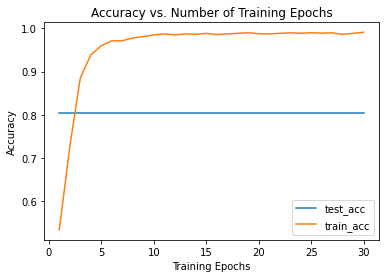

In [ ]:
plt.title("Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Accuracy")
plt.plot(range(1,len(test_acc)+1),test_acc,label="test_acc")
plt.plot(range(1,len(train_acc)+1),train_acc,label="train_acc")
plt.legend()
plt.savefig("/content/drive/Shareddrives/CIS 522/code/output/{}_{}.png".format("meta_DL_w_sentiment", "acc"))
plt.show()

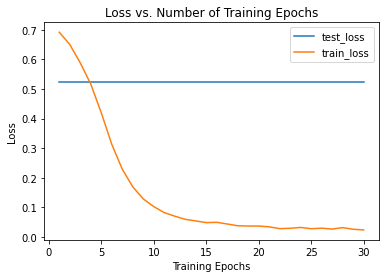

In [ ]:
plt.title("Loss vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Loss")
plt.plot(range(1,len(test_loss)+1),test_loss,label="test_loss")
plt.plot(range(1,len(train_loss)+1),train_loss,label="train_loss")
plt.legend()
plt.savefig("/content/drive/Shareddrives/CIS 522/code/output/{}_{}.png".format("meta_DL_w_sentiment", "loss"))
plt.show()

In [ ]:
y_true, y_pred = get_predictions(meta_net, test_loader, DEVICE)
print(classification_report(y_true, y_pred))
print(confusion_matrix(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.86      0.80       105
           1       0.80      0.68      0.73        90

    accuracy                           0.77       195
   macro avg       0.78      0.77      0.77       195
weighted avg       0.78      0.77      0.77       195

[[90 15]
 [29 61]]


**Results from adding sentiment analysis**: no difference in performance to metadata DL model when adding sentiment score to features.

# Final Multimodal Model
 

## Multimodal Data Loader

In [ ]:
class TikTokDataset_mm(Dataset):
    def __init__(self, df):
        self.df = df
        self.input_size = (120*16,120*9)
        self.transform = transforms.Compose([
            transforms.RandomResizedCrop(self.input_size),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.df['id'])

    def __getitem__(self, idx):
        image_folder = "/content/drive/Shareddrives/CIS 522/code/input/TikTok Data/batch_4_100000/"
        image = Image.open("{}/{}.png".format(image_folder, self.df.loc[idx]['id'])).convert('RGB')
        img = self.transform(image)
        meta_sentiment = torch.Tensor(self.df.drop(columns=['id', 'label', 'transcribed']).loc[idx])
        label = self.df.loc[idx]['label']
        return meta_sentiment, img, label

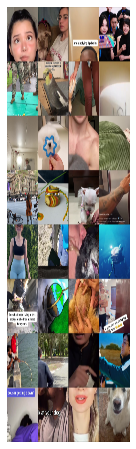

In [ ]:
# To preserve reproducibility
g_seed = torch.Generator()
g_seed.manual_seed(SEED)
batch_size = 32

# Load data
train_loader = DataLoader(TikTokDataset_mm(train_df),
                          num_workers=0, 
                          batch_size=batch_size,
                          shuffle=True,
                          worker_init_fn=seed_worker,
                          generator=g_seed)
test_loader = DataLoader(TikTokDataset_mm(test_df), 
                         num_workers=0, 
                         batch_size=batch_size,
                         shuffle=False,
                         worker_init_fn=seed_worker,
                         generator=g_seed)

dataiter = iter(test_loader)
meta_data, images, labels = dataiter.next()

# Show images
plt.figure(figsize=(8, 8))
plt.imshow(make_grid(images, nrow=4).permute(1, 2, 0))
plt.axis('off')
plt.show()

## `CNN_mm` class

In [ ]:
class CNN_mm(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, stride=2)
        self.pool1 = nn.MaxPool2d(4, 4)
        self.conv2 = nn.Conv2d(16, 32, 3, stride=2)
        self.pool2 = nn.MaxPool2d(4, 4)
        
        self.drop_out = nn.Dropout(0.3)

        self.fc1 = nn.Linear(14848, 10024)
        self.fc2 = nn.Linear(10024, 1024)
        self.fc3 = nn.Linear(1024, 256)
        self.fc4 = nn.Linear(256, 32)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.drop_out(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        return x

## Multimodal `train_mm()`, `eval_mm()`, `get_predictions_mm()` functions

In [ ]:
# Train
def train_mm(cnn, combine_net, optimizer, train_loader,
                          loss_fn, device, num_epochs=5):
  """
  Training loop

  Args:
    model: nn.module
      Untrained model
    optimizer: function
      Optimizer
    train_loader: torch.loader
      Training loader
    loss_fn: function
      Criterion
    device: string
      If available, GPU/CUDA. CPU otherwise

  Returns:
    model: nn.module
      Trained model
    train_loss: List(float)
      List of train losses at each epoch
    train_acc: List(float)
      List of train accuracies at each epoch
  """
  train_loss = []
  train_acc = []

  for epoch in tqdm.notebook.tqdm(range(num_epochs)):
    # Set model to use the classifier head
    cnn.train()
    combine_net.train()

    # Train on a batch of images
    running_loss = []
    running_acc = []

    for batch in train_loader:
      meta_sentiment, images, labels = batch

      meta_sentiment = meta_sentiment.to(device)
      images = images.to(device)
      labels = labels.to(device)

      # output from ResNet/CNN model
      img_outputs = cnn(images)

      # combine two inputs and put into combine_net
      combined_input = torch.hstack((img_outputs, meta_sentiment))
      outputs = combine_net(combined_input)
      
      optimizer.zero_grad()
      loss = loss_fn(outputs, labels)
      loss.backward()
      optimizer.step()

      _, predicted = torch.max(outputs.data, 1)

      running_loss.append(loss.item())
      running_acc.append((predicted == labels).sum().item()/labels.size(0))

    train_loss.append(np.mean(running_loss))
    train_acc.append(np.mean(running_acc))

  return cnn, combine_net, train_loss, train_acc

In [ ]:
# Evalute
def eval_mm(cnn, combine_net, test_loader, loss_fn, device, num_epochs=5):
  """
  Evaluation loop

  Args:
    model: nn.module
      Untrained model
    test_loader: torch.loader
    loss_fn: function
      Criterion
    device: string
      If available, GPU/CUDA. CPU otherwise

  Returns:
    test_loss: List(float)
      List of test losses at each epoch
    test_acc: List(float)
      List of test accuracies at each epoch
  """

  test_loss = []
  test_acc = []

  for epoch in tqdm.notebook.tqdm(range(num_epochs)):
    # Set model to use the classifier head
    cnn.eval()
    combine_net.eval()

    # Evaluate model on a batch of images
    running_loss = []
    running_acc = []

    for batch in test_loader:
      meta_sentiment, images, labels = batch
      
      meta_sentiment = meta_sentiment.to(device)
      images = images.to(device)
      labels = labels.to(device)

      # output from ResNet/CNN model
      img_outputs = cnn(images)

      # combine two outputs and put into combine_net
      combined_input = torch.hstack((img_outputs,meta_sentiment))
      outputs = combine_net(combined_input)

      loss = loss_fn(outputs, labels)
      
      _, predicted = torch.max(outputs.data, 1)
      
      running_loss.append(loss.item())
      running_acc.append((predicted == labels).sum().item()/labels.size(0))

    test_loss.append(np.mean(running_loss))
    test_acc.append(np.mean(running_acc))

  return test_loss, test_acc

In [ ]:
def get_predictions_mm(cnn, combine_net, test_loader, device):
  y_pred = []
  y_true = []
  cnn.eval()
  combine_net.eval()
  for batch in test_loader:
      meta_sentiment, img, labels = batch

      meta_sentiment = meta_sentiment.to(device)
      img = img.to(device)
      labels = labels.to(device)

      # output from ResNet/CNN model
      img_outputs = cnn(img)

      # combine two outputs and put into combine_net
      combined_input = torch.hstack((img_outputs,meta_sentiment))
      outputs = combine_net(combined_input)
      _, predicted = torch.max(outputs.data, 1)
      y_true.append(labels.cpu().numpy())
      y_pred.append(predicted.cpu().numpy())
  y_true = np.concatenate(tuple(y_true))
  y_pred = np.concatenate(tuple(y_pred))
  return y_true, y_pred
  

## Training

In [ ]:
meta_inputs = train_df.drop(columns=['id', 'label', 'transcribed']).shape[1]

# CNN for images
cnn = CNN_mm().to(DEVICE)

# Fully Connected NN for final combination of the modalities
combine_net = Net(actv='ReLU()',
    num_inputs = 32+meta_inputs,
    hidden_units = [512, 64],
    num_outputs = 2).to(DEVICE)

opt = torch.optim.Adam(combine_net.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()
num_epochs = 30

# Train on TikTok dataset
cnn_trained, combine_net_trained, train_loss, train_acc = train_mm(
    cnn, combine_net, opt, train_loader, loss_fn, DEVICE, num_epochs=num_epochs)



  0%|          | 0/30 [00:00<?, ?it/s]

In [ ]:
# Evaluate
test_loss, test_acc = eval_mm(
    cnn_trained, combine_net_trained, test_loader, loss_fn, DEVICE, num_epochs=num_epochs)

  0%|          | 0/30 [00:00<?, ?it/s]

## Results

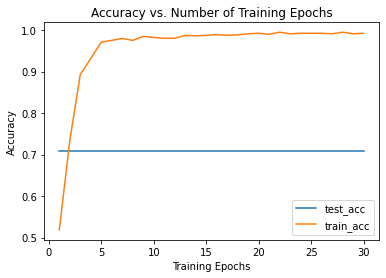

In [ ]:
plt.title("Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Accuracy")
plt.plot(range(1,len(test_acc)+1),test_acc,label="test_acc")
plt.plot(range(1,len(train_acc)+1),train_acc,label="train_acc")
plt.legend()
plt.savefig("/content/drive/Shareddrives/CIS 522/code/output/{}_{}.png".format("multimodal_simplified_DL", "acc"))
plt.show()

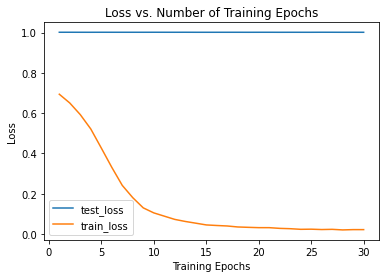

In [ ]:
plt.title("Loss vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Loss")
plt.plot(range(1,len(test_loss)+1),test_loss,label="test_loss")
plt.plot(range(1,len(train_loss)+1),train_loss,label="train_loss")
plt.legend()
plt.savefig("/content/drive/Shareddrives/CIS 522/code/output/{}_{}.png".format("multimodal_simplified_DL", "loss"))
plt.show()

In [ ]:
y_true, y_pred = get_predictions_mm(cnn_trained, combine_net_trained, test_loader, DEVICE)
print(classification_report(y_true, y_pred))
print(confusion_matrix(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.80      0.79       109
           1       0.74      0.72      0.73        86

    accuracy                           0.76       195
   macro avg       0.76      0.76      0.76       195
weighted avg       0.76      0.76      0.76       195

[[87 22]
 [24 62]]
